In [3]:
import pandas as pd
import numpy as np

In [4]:
data = pd.read_csv('./data/data.csv')

### Анализ

Анализ остается в точности тем же самым, что и в первом домашнем задании. Сначала удалим ненужные столбцы

In [5]:
to_drop = ["banner_id0", "banner_id1", "rate0", "rate1", "g0", "g1", "coeff_sum0", "coeff_sum1"]
data = data.drop(to_drop, axis=1)
data.head()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,impressions,clicks
0,2021-09-27 00:01:30.000000,0,0,5664530014561852622,0,0,0,1,1
1,2021-09-26 22:54:49.000000,1,1,5186611064559013950,0,0,1,1,1
2,2021-09-26 23:57:20.000000,2,2,2215519569292448030,3,0,0,1,1
3,2021-09-27 00:04:30.000000,3,3,6262169206735077204,0,1,1,1,1
4,2021-09-27 00:06:21.000000,4,4,4778985830203613115,0,1,0,1,1


Посмотрим на столбец impressions, пока кажется, что он не несет информации.

In [6]:
data.groupby("impressions").count()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,clicks
impressions,,,,,,,,
1,15821472,15821472,15821472,15821472,15821472,15821472,15821472,15821472


In [7]:
data = data.drop("impressions", axis=1)

Проверим, есть ли None:

In [8]:
data.isnull().value_counts()

date_time  zone_id  banner_id  oaid_hash  campaign_clicks  os_id  country_id  clicks
False      False    False      False      False            False  False       False     15821472
dtype: int64

Таких значений нет, чистить датасет не нужно. Посмотрим на статистику по дням

In [9]:
data["date_time"] = pd.to_datetime(data["date_time"])
data['date'] = data.date_time.dt.date
data.date.value_counts()

2021-09-26    3102610
2021-09-29    2420588
2021-09-27    2367303
2021-09-28    2307355
2021-10-02    2128978
2021-09-30    1851189
2021-10-01    1643448
2021-09-01          1
Name: date, dtype: int64

По одному из дней только одна запись, выбросим его.

In [10]:
import datetime
data = data.drop(data[data["date"] == datetime.date(2021, 9, 1)].index.asi8)
data = data.sort_values(by='date')
data.date.value_counts()

/tmp/ipykernel_8343/2394282383.py:2: FutureWarning: Index.asi8 is deprecated and will be removed in a future version.
  data = data.drop(data[data["date"] == datetime.date(2021, 9, 1)].index.asi8)


2021-09-26    3102610
2021-09-29    2420588
2021-09-27    2367303
2021-09-28    2307355
2021-10-02    2128978
2021-09-30    1851189
2021-10-01    1643448
Name: date, dtype: int64

Из данной в README информации можно сделать вывод, что все фичи, кроме campaign_click, категориальные. К ним в последствии применим One Hot encoding. Посмотрим ближе на величину campaign cliсks - насколько велики значения, какое распределение

In [11]:
data.campaign_clicks.max()

829

<AxesSubplot:xlabel='number of clicks'>

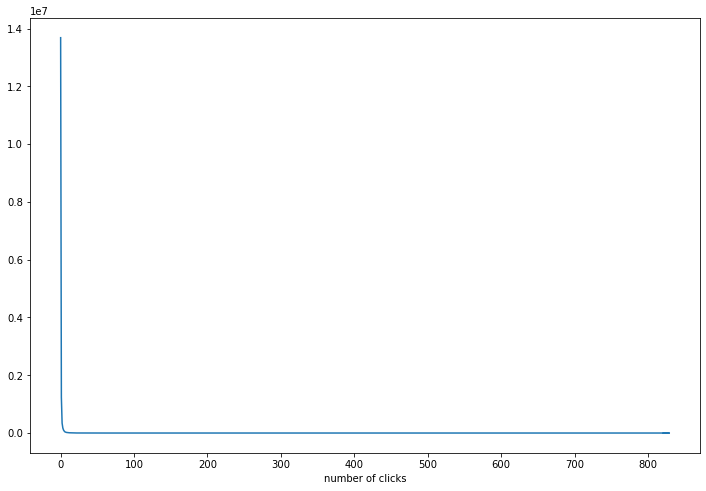

In [12]:
data.campaign_clicks.value_counts().plot(figsize=(12, 8), xlabel="number of clicks", xticks=np.arange(0, 900, 100))

Видим, что распределение перекошено. Было бы хорошо придумать такое преобразование, которое бы "растянуло" распределение, то есть область маленьких величин сделало пошире, а больших сгладило. В таких случаях обычно используют логарифм.

### Преобразование данных и обучение модели.

Для дальнейших экспериментов используем библиотеку [xlearn](https://xlearn-doc.readthedocs.io/en/latest/python_api/index.html#choose-machine-learning-algorithm). Чтобы воспользоваться ею, данные нужно перевести в определенный формат (libfmm), поэтому дальше нам не будет нужен OneHotEncoding

В отличие от первого домашнего задания, здесь нужны будут данные для валидации. Для этого выделим предпоследний день.

In [13]:
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack

def feature_engineering(data: pd.DataFrame):

    data["campaign_clicks"] = np.log(data['campaign_clicks']+1e-4)

    train = data[data["date"] < datetime.date(2021, 10, 1)]
    val = data[data["date"] == datetime.date(2021, 10, 1)]
    test = data[data["date"] == datetime.date(2021, 10, 2)]

    train = train.drop(["date", "date_time"], axis=1)
    val = val.drop(["date", "date_time"], axis=1)
    test = test.drop(["date", "date_time"], axis=1)

    return train, val, test

In [14]:
train, val, test = feature_engineering(data)

In [14]:
train.head()

,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,clicks
3398262,302,403,6294099772840197869,-9.21034,2,6,0
12412212,38,753,7246070537034303857,-9.21034,4,0,0
5092342,3,1237,7290717137500041108,-9.21034,4,0,0
2526141,20,140,5119833759207605654,-9.21034,2,0,0
12412207,54,36,7860369112178585780,-9.21034,1,0,0


Для того чтобы перевести наши данные в нужный формат, воспользуемся функцией из следующего источника ([статья](https://wngaw.github.io/field-aware-factorization-machines-with-xlearn/)): https://github.com/wngaw/blog/blob/master/xlearn_example/src/utils.py

In [15]:
import json
import math
from tqdm import tqdm

def _convert_to_ffm(path, df, type, target, numerics, categories, features, encoder):
    # Flagging categorical and numerical fields
    print('convert_to_ffm - START')
    for x in numerics:
        if(x not in encoder['catdict']):
            encoder['catdict'][x] = 0
    for x in categories:
        if(x not in encoder['catdict']):
            encoder['catdict'][x] = 1

    nrows = df.shape[0]
    with open(path + str(type) + "_ffm.txt", "w") as text_file:

        # Looping over rows to convert each row to libffm format
        for n, r in enumerate(tqdm(range(nrows))):
            datastring = ""
            datarow = df.iloc[r].to_dict()
            datastring += str(int(datarow[target]))  # Set Target Variable here

            # For numerical fields, we are creating a dummy field here
            for i, x in enumerate(encoder['catdict'].keys()):
                if(encoder['catdict'][x] == 0):
                    # Not adding numerical values that are nan
                    if math.isnan(datarow[x]) is not True:
                        datastring = datastring + " "+str(i)+":" + str(i)+":" + str(datarow[x])
                else:

                    # For a new field appearing in a training example
                    if(x not in encoder['catcodes']):
                        encoder['catcodes'][x] = {}
                        encoder['currentcode'] += 1
                        encoder['catcodes'][x][datarow[x]] = encoder['currentcode']  # encoding the feature

                    # For already encoded fields
                    elif(datarow[x] not in encoder['catcodes'][x]):
                        encoder['currentcode'] += 1
                        encoder['catcodes'][x][datarow[x]] = encoder['currentcode']  # encoding the feature

                    code = encoder['catcodes'][x][datarow[x]]
                    datastring = datastring + " "+str(i)+":" + str(int(code))+":1"

            datastring += '\n'
            text_file.write(datastring)

    return encoder

Разделим фичи на числовые и категориальные

In [16]:
num_features = ["campaign_clicks"]
cat_features = ["zone_id", "banner_id", "oaid_hash", "os_id", "country_id"]
features = num_features+cat_features
train.columns

Index(['zone_id', 'banner_id', 'oaid_hash', 'campaign_clicks', 'os_id',
       'country_id', 'clicks'],
      dtype='object')

Сохраним преобразованные данные в отдельных файлах.

In [17]:
# Initialise fields and variables encoder
encoder = {"currentcode": len(num_features),  # Unique index for each numerical field or categorical variables
           "catdict": {},  # Dictionary that stores numerical and categorical variables
           "catcodes": {}}  # Dictionary that stores index for each categorical variables per categorical field

In [18]:
"""
encoder = _convert_to_ffm('./data/', train, 'train1', 'clicks',
                          num_features,
                          cat_features,
                          features,
                          encoder)"""

"\nencoder = _convert_to_ffm('./data/', train, 'train1', 'clicks',\n                          num_features,\n                          cat_features,\n                          features,\n                          encoder)"

In [19]:
"""
encoder = _convert_to_ffm('./data/', val, 'val1', 'clicks',
                          num_features,
                          cat_features,
                          features,
                          encoder)
                          """

"\nencoder = _convert_to_ffm('./data/', val, 'val1', 'clicks',\n                          num_features,\n                          cat_features,\n                          features,\n                          encoder)\n                          "

In [20]:
"""encoder = _convert_to_ffm('./data/', test, 'test1', 'clicks',
                          num_features,
                          cat_features,
                          features,
                          encoder)"""

"encoder = _convert_to_ffm('./data/', test, 'test1', 'clicks',\n                          num_features,\n                          cat_features,\n                          features,\n                          encoder)"

Обучим модель: будем менять параметры k и lambda.

In [1]:
import xlearn as xl
from sklearn.model_selection import ParameterGrid

params = {
    'task': ['binary'],
    'lr': [0.15],
    'lambda':[1e-2, 1e-3, 5e-4, 1e-4],
    'k': [4],
    'metric': ['auc'],
    'epoch': [35],
    'opt': ['adagrad']
}

In [2]:
for item in ParameterGrid(params):
    print(item)
    ffm_model = xl.create_ffm()
    ffm_model.setTrain("./data/train1_ffm.txt")
    ffm_model.setValidate("./data/val1_ffm.txt")
    ffm_model.fit(item, f"./models/model{item['lambda']}_{item['k']}.out")

{'epoch': 35, 'k': 4, 'lambda': 0.01, 'lr': 0.15, 'metric': 'auc', 'opt': 'adagrad', 'task': 'binary'}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./data/train1_ffm.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./data/val1_ffm.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature

In [2]:

params = {
    'task': ['binary'],
    'lr': [0.15],
    'lambda':[1e-2, 1e-3, 5e-4, 1e-4],
    'k': [6],
    'metric': ['auc'],
    'epoch': [35],
    'opt': ['adagrad']
}
for item in ParameterGrid(params):
    print(item)
    ffm_model = xl.create_ffm()
    ffm_model.setTrain("./data/train1_ffm.txt")
    ffm_model.setValidate("./data/val1_ffm.txt")
    ffm_model.fit(item, f"./models/model{item['lambda']}_{item['k']}.out")

{'epoch': 35, 'k': 6, 'lambda': 0.01, 'lr': 0.15, 'metric': 'auc', 'opt': 'adagrad', 'task': 'binary'}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./data/train1_ffm.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./data/val1_ffm.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature

Теперь обучим лучшую модель и проверим ее на тестовой выборке.

In [2]:
best_p = {'epoch': 35, 'k': 4, 'lambda': 0.0001, 'lr': 0.15, 'metric': 'auc', 'opt': 'adagrad', 'task': 'binary'}
ffm_model = xl.create_ffm()
ffm_model.setTrain("./data/train1_ffm.txt")
ffm_model.setTest('./data/test1_ffm.txt')
ffm_model.setSigmoid()
ffm_model.predict("./models/model0.0001_4.out", "./data/result.txt")

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for prediction task.
[ ACTION     ] Load model ...
[------------] Load model from ./models/model0.0001_4.out
[------------] Loss function: cross-entropy
[------------] Score function: ffm
[------------] Number of Feature: 5665363
[------------] Number of K: 4
[------------] Number of field: 6
[------------] Time cost for loading model: 0.69 (sec)
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./data/test1_ffm.txt.bin) NOT found. Convert text fi

In [16]:
y_model = pd.read_csv("./data/result.txt", header=None)
y_test = test['clicks']
from sklearn.metrics import log_loss, roc_auc_score
print(f"My model: NNL = {log_loss(y_test, y_model)}, ROC AUC = {roc_auc_score(y_test, y_model)}")

My model: NNL = 0.13556384117468007, ROC AUC = 0.7623435960452609


Для линейной модели результат был таким: NNL = 0.13363618401953573, ROC AUC = 0.7789599619007965, что близко к тому, что я смогла получить с FFM. Возможно, при переборе большего количества значений гиперпараметров результат был бы лучше.